<a href="https://colab.research.google.com/github/PhatDat09/Sentiment_Analyst_EngData/blob/main/DoAnCoSo_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPooling1D,LayerNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/Data/Test.csv'
data = pd.read_csv(file_path)
data.head()

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


In [4]:
sentiment_data = pd.DataFrame({'input': data['text'], 'lable': data['label']})
sentiment_data = sentiment_data.dropna()
sentiment_data = sentiment_data.reset_index(drop=True)
sentiment_data.head()

,input,lable
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


In [5]:
input_data = sentiment_data['input'].values
input_lable = sentiment_data['lable'].values

input_pre = []
lable_with_accent = []
for idx , dt in enumerate(input_data):
  input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
  input_text_pre = " ".join(input_text_pre)
  input_pre.append(input_text_pre)
  lable_with_accent.append(input_lable[idx])

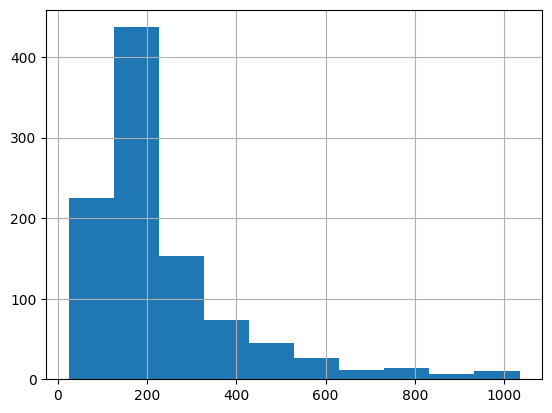

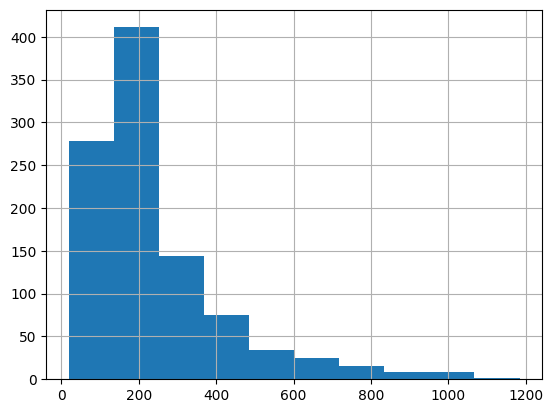

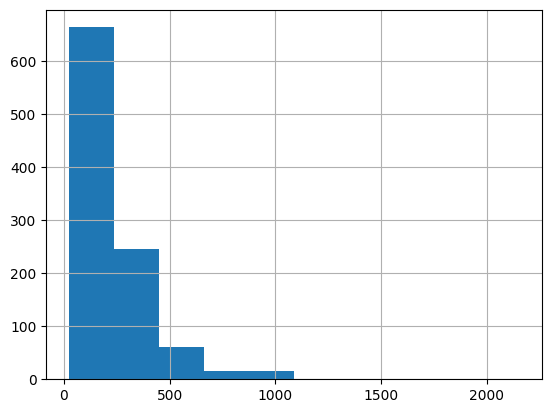

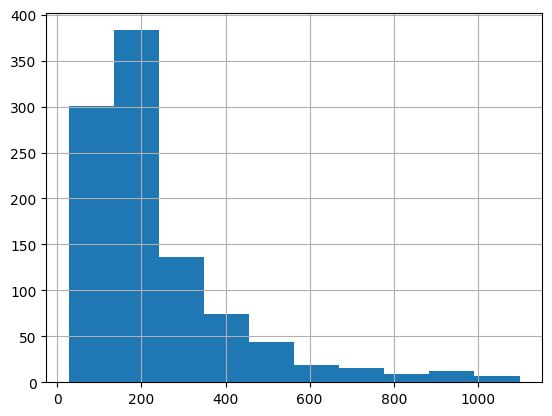

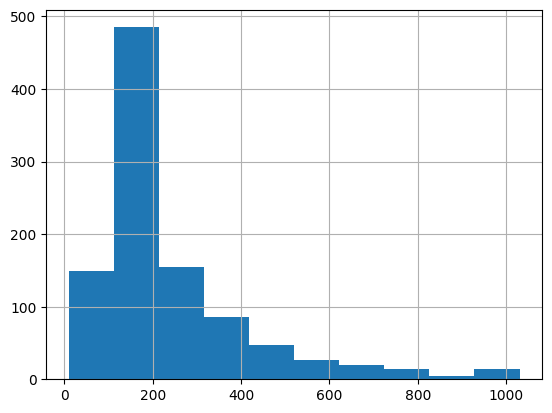

In [6]:
seq_len = [len(i.split()) for i in input_pre[0:1000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[1000:2000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[2000:3000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[3000:4000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[4000:5000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

In [7]:

lable_idx = [int(lable) for lable in lable_with_accent]
lable_tf = tf.keras.utils.to_categorical(lable_idx, num_classes= 2, dtype='float32')

tokenizer_data = Tokenizer(oov_token='<00V>', filters = '',split = ' ')
tokenizer_data.fit_on_texts(input_pre)

tokenized_data_text = tokenizer_data.texts_to_sequences(input_pre)
vec_data = pad_sequences(tokenized_data_text,padding='post',maxlen=430)

pickle.dump(tokenizer_data, open("tokenizer_data.pkl","wb"))

print("input data.shape ",vec_data.shape)
data_vocab_size = len(tokenizer_data.word_index)+1
print("data_vocab_size: ",data_vocab_size)

X_train, X_val, y_train, y_val = train_test_split(vec_data, lable_tf, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
print("training sample: ",len(X_train))
print("valication sample: ",len(X_val))
print("test sample: ",len(X_test))

input data.shape  (5000, 430)
data_vocab_size:  43603
training sample:  3600
valication sample:  1000
test sample:  400


In [8]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras import Model

In [9]:
def generate_model():
    dropout_threshold = 0.4
    input_dim = data_vocab_size
    output_dim = 32
    input_length = 430
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, embeddings_initializer="GlorotNormal")(input_layer)

    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode='concat')(feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = Bidirectional(GRU(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode='concat')(bi_lstm_feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    combine_feature = Concatenate()([cnn_feature, bi_lstm_feature])
    combine_feature = GlobalMaxPooling1D()(combine_feature)
    combine_feature = LayerNormalization()(combine_feature)

    classifier = Dense(90, activation='relu')(combine_feature)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(70, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(50, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(30, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(2, activation='softmax')(classifier)

    model = Model(inputs=input_layer, outputs=classifier)

    return model

# Giả sử data_vocab_size đã được định nghĩa trước đó
data_vocab_size = 100000

# Tạo mô hình
model = generate_model()

# Biên dịch mô hình
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# In ra cấu trúc mô hình
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 430)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 430, 32)              3200000   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 430, 32)              3104      ['embedding[0][0]']           
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 215, 32)              0         ['conv1d[0][0]']              
 D)                                                                                           

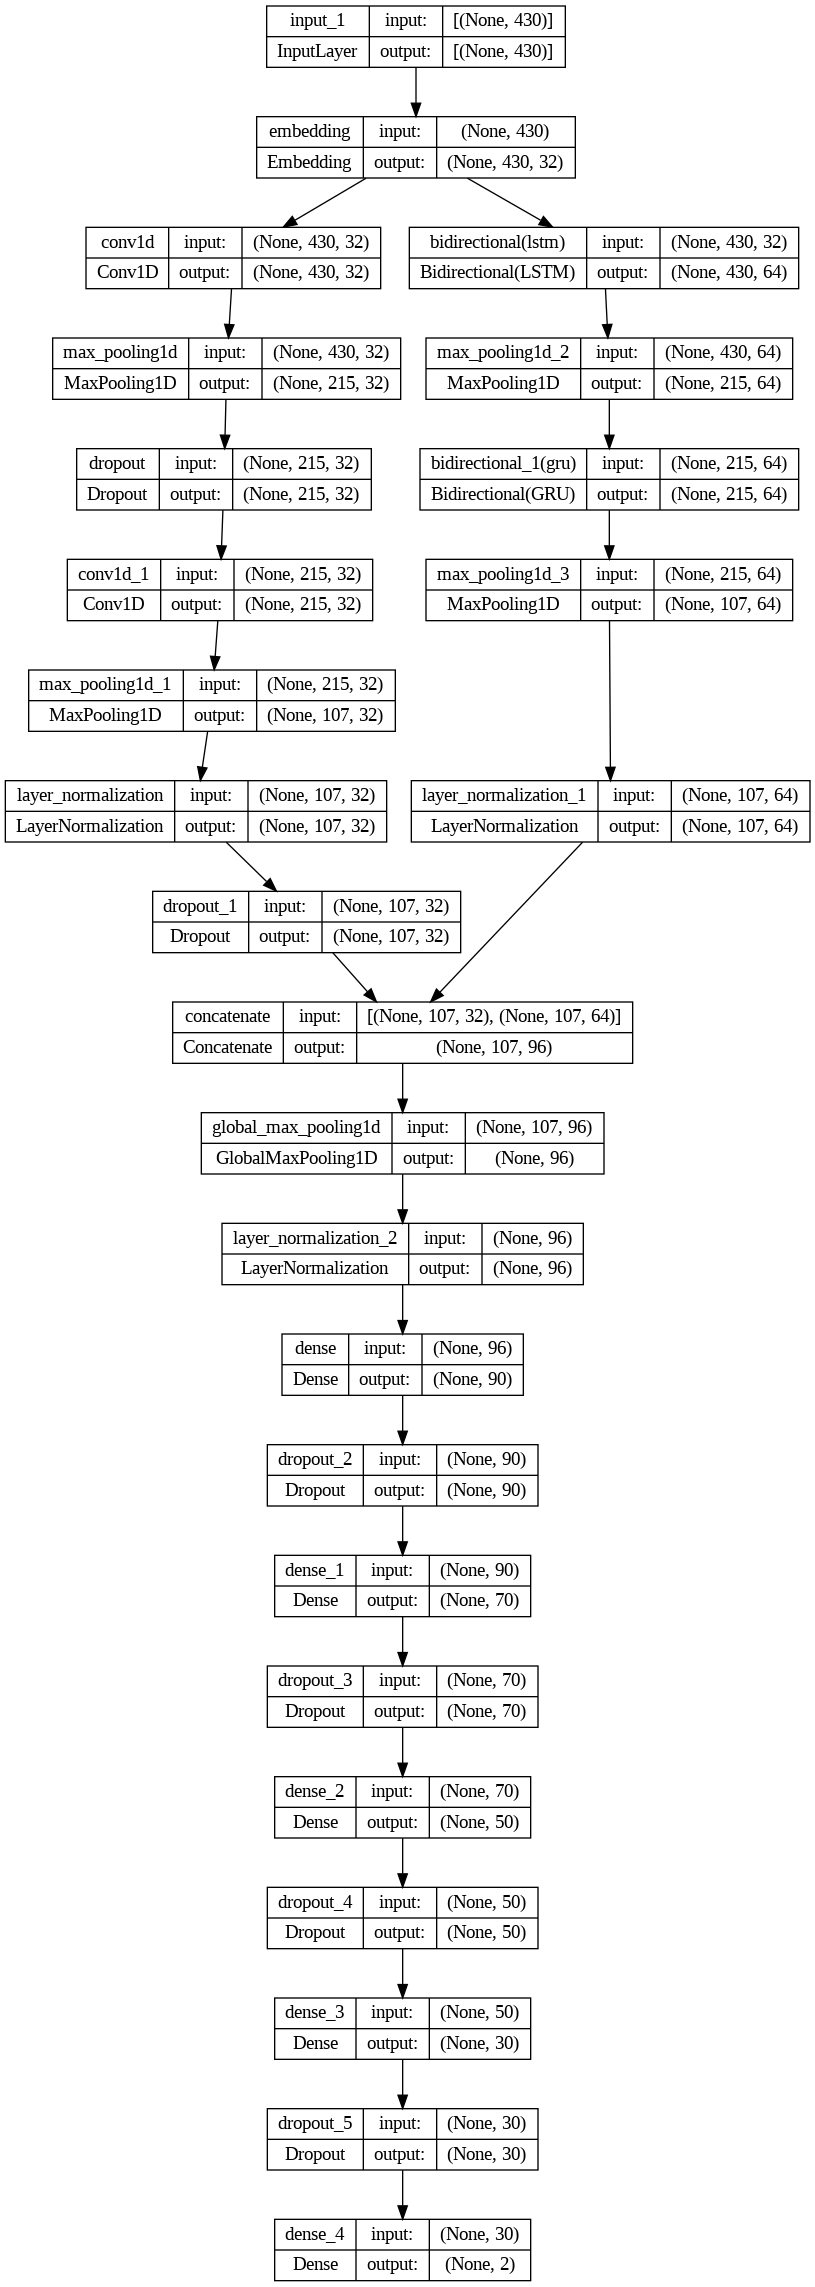

In [10]:
dot_img_file = 'model_visualize.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [11]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.h5',monitor='val_loss')
history = model.fit(x = X_train, y = y_train, validation_data = (X_val,y_val),epochs = 10, batch_size = 128, callbacks = [callback_model] )

Epoch 1/10
29/29 [==============================] - 52s 1s/step - loss: 0.7089 - accuracy: 0.4906 - val_loss: 0.6935 - val_accuracy: 0.4980
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 36s 1s/step - loss: 0.6938 - accuracy: 0.4986 - val_loss: 0.6934 - val_accuracy: 0.4980
Epoch 3/10
29/29 [==============================] - 36s 1s/step - loss: 0.6943 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.4930
Epoch 4/10
29/29 [==============================] - 38s 1s/step - loss: 0.6945 - accuracy: 0.4917 - val_loss: 0.6930 - val_accuracy: 0.5030
Epoch 5/10
29/29 [==============================] - 35s 1s/step - loss: 0.6942 - accuracy: 0.5011 - val_loss: 0.6935 - val_accuracy: 0.4970
Epoch 6/10
29/29 [==============================] - 35s 1s/step - loss: 0.6927 - accuracy: 0.5244 - val_loss: 0.6929 - val_accuracy: 0.5300
Epoch 7/10
29/29 [==============================] - 38s 1s/step - loss: 0.6931 - accuracy: 0.5064 - val_loss: 0.6922 - val_accuracy: 0.5080
Epoch 8/10
29/29 [==============================] - 35s 1s/step - loss: 0.6915 - accuracy: 0.5292 - val_loss: 0.6929 - val_accuracy: 0.5030
Epoch 9/10
29/29 [=============

In [12]:
model.load_weights("model_cnn_bilstm.h5")
model.evaluate(X_test,y_test)

13/13 [==============================] - 1s 114ms/step - loss: 0.5017 - accuracy: 0.8025


[0.5016524791717529, 0.8025000095367432]

In [13]:
def preprocess_raw_input(raw_input,tokenizer):
  input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
  input_text_pre = " ".join(input_text_pre)
  print("Text preprocesse:", input_text_pre)
  tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre])
  vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen = 430)
  return vec_data

def inference_model(input_feature, model):
  output = model(input_feature).numpy()[0]
  result = output.argmax()
  conf = float(output.max())
  lable_dict =  {'negative':0,'positive':1}
  lable = list(lable_dict.keys())
  return lable[int(result)],conf

def prediction(raw_input, tokenizer, model):
  input_model = preprocess_raw_input(raw_input, tokenizer_data)
  result, conf = inference_model(input_model, model)

  return result, conf

my_model = generate_model()
my_model = load_model('model_cnn_bilstm.h5')

with open(r'tokenizer_data.pkl',"rb") as input_file:
  my_tokenizer = pickle.load(input_file)

print(prediction("this product is so delicious", my_tokenizer, my_model))
print(prediction("oh my god, i felt headache when i ate food lastday", my_tokenizer, my_model))

Text preprocesse: this product is so delicious
('positive', 0.5169547200202942)
Text preprocesse: oh my god i felt headache when i ate food lastday
('negative', 0.8552417755126953)


In [14]:
while(True):
    text = input()
    if text == "end":
      break
    else: print(prediction(text, my_tokenizer, my_model)[0] + "\n")

what a beautiful day
Text preprocesse: what a beautiful day
positive

end
